##### Help Articles:
* https://robjhyndman.com/hyndsight/cyclicts/
* https://www.datascience.com/blog/introduction-to-forecasting-with-arima-in-r-learn-data-science-tutorials

# 1. Loading Libraries

In [430]:
### For all sorts of plotting
library(ggplot2)
library(gridExtra)

### For Arima Modelig
library(forecast)
library(tseries)


# Loading colour pallete librarry
library(RColorBrewer)
# Loading 12 colours from Paired pallert into our vector "my_pallete"
my_palette = c(brewer.pal(12, "Paired")[c(1:12)])
my_palette

# For Accuracy prediction function 
library(Metrics)

[1] "#A6CEE3" "#1F78B4" "#B2DF8A" "#33A02C" "#FB9A99" "#E31A1C" "#FDBF6F"
 [8] "#FF7F00" "#CAB2D6" "#6A3D9A" "#FFFF99" "#B15928"

## 1.1 Loading Pallets

In [431]:
## Will use this for colouring 
my_palette=c('#1F78B4' , '#E31A1C', '#A6CEE3', '#B2DF8A', '#33A02C', '#FB9A99',  '#FDBF6F' ,'#FF7F00', '#CAB2D6', '#6A3D9A', '#FFFF99', '#B15928')
myp=my_palette

## 1.2 Listing Data folder

In [432]:
# LIsting file in the directory
list.files("./Data")

[1] "ADANIENT.NS.csv" "IDFC.NS.csv"

## 1.3 Loading DataFrame

In [433]:
#Fortis health care 

## Readig Csv file 
df=read.csv(file="./Data/IDFC.NS.csv", stringsAsFactors=FALSE)
# convertinf date colums to type data
df$Date=as.Date(df$Date)
# Converting close to numeric or else it is trated as factor variable 
df$Close=as.numeric(df$Close)
## Selecting date
df=df[ (df$Date>"2016-01-01") & (df$Date<"2018-12-31"), ]
tail(df)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

,Date,Open,High,Low,Close,Adj.Close,Volume
3299,2018-12-20,41.599998,44.950001,41.299999,44.00,44.000000,7724128
3300,2018-12-21,44.250000,44.500000,42.650002,42.90,42.900002,4509452
3301,2018-12-24,42.900002,43.900002,42.299999,43.20,43.200001,3047812
3302,2018-12-26,43.150002,43.650002,42.000000,43.45,43.450001,3437635
3303,2018-12-27,43.500000,44.049999,42.500000,42.85,42.849998,4107116
3304,2018-12-28,43.400002,43.750000,42.900002,43.40,43.400002,3433418


## 1.4 Cleaning Data

In [434]:
## removing all columns except close and returns
df=df[, c(1,5)]
head(df)

,Date,Close
2567,2016-01-04,47.80
2568,2016-01-05,48.50
2569,2016-01-06,47.85
2570,2016-01-07,46.70
2571,2016-01-08,46.60
2572,2016-01-11,45.90


## 1.5 Calculating  Returns 

In [435]:
df$Returns=c(NA, diff(log(df$Close)))
head(df)

,Date,Close,Returns
2567,2016-01-04,47.80,NA
2568,2016-01-05,48.50,0.014538179
2569,2016-01-06,47.85,-0.013492722
2570,2016-01-07,46.70,-0.024326890
2571,2016-01-08,46.60,-0.002143688
2572,2016-01-11,45.90,-0.015135338


## 1.6 Spliting Dataset with Test Set of 8

In [436]:
### You can sepecify delta here in order to have diffrent amount of train andtest dataset
delta=10
total=nrow(df)
start=1
split=total-delta

# df[start:split, ]
df2=df[(split+1):total, ]
df=df[start:split,]

## 1.7 Removing empty rows and Stacking data for plotting(ggplots2) 

In [437]:
df=df[complete.cases(df),]
dfs=stack(df)
head(dfs)

Warning message in stack.data.frame(df):
“non-vector columns will be ignored”

values,ind
48.50,Close
47.85,Close
46.70,Close
46.60,Close
45.90,Close
45.10,Close


## 1.8 Plotting Kernel density graph for normality and Box plot for outliers

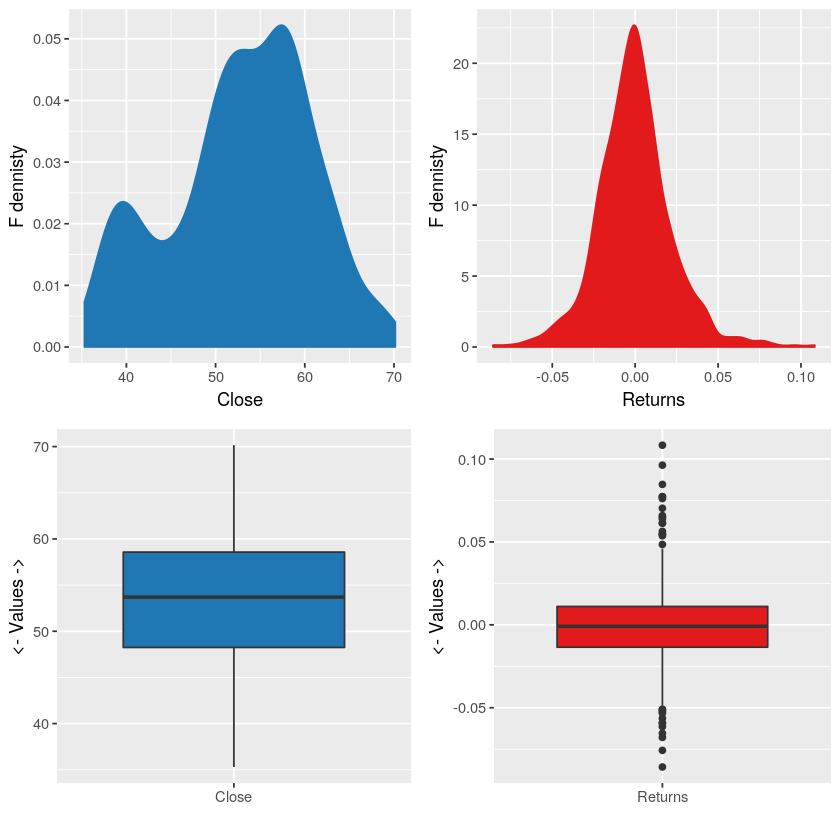

In [438]:
col_name=c("Close", "Returns")
p=list()

### Normality
for(i in 1:2){
    col=col_name[i]
    dfp=subset(dfs, dfs$ind==col)
    p_plot=ggplot(dfp, aes(x=values))+
              geom_density(color=my_palette[i], fill=my_palette[i])+
              labs(x=col, y="F dennisty")
## Saving plots 
    p[[i]]=p_plot
}

## Box PLot
for(i in 1:2){
    col=col_name[i]
    dfp=subset(dfs, dfs$ind==col)
    p_plot=ggplot(dfp, aes(ind,values))+
              geom_boxplot(fill=my_palette[i])+
              labs(x="", y="<- Values ->")
## Saving on all plots from abve 
    p[[i+2]]=p_plot
}



grid.arrange(p[[1]],p[[2]],
             p[[3]],p[[4]], 
             ncol=2)

## 1.8 Conclusion
##### From above plots we can conclude that 

1. Close price is not normally distributed and has multiple mode 
2. Returns are normally distributed
3. Close price do not have any outlier
4. Returns do have outliers, but they can be ignored as the value of returns are too low

# 2. Starting Box-Jenkins procedure for ARIMA modeling 
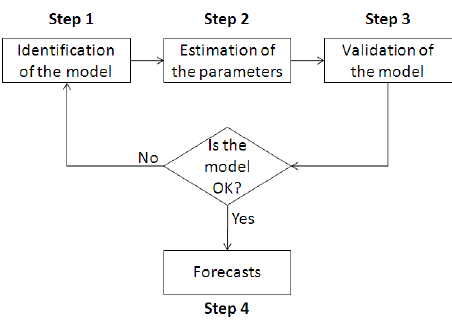

## 2.1 Stationarity Check by Visual Inspection

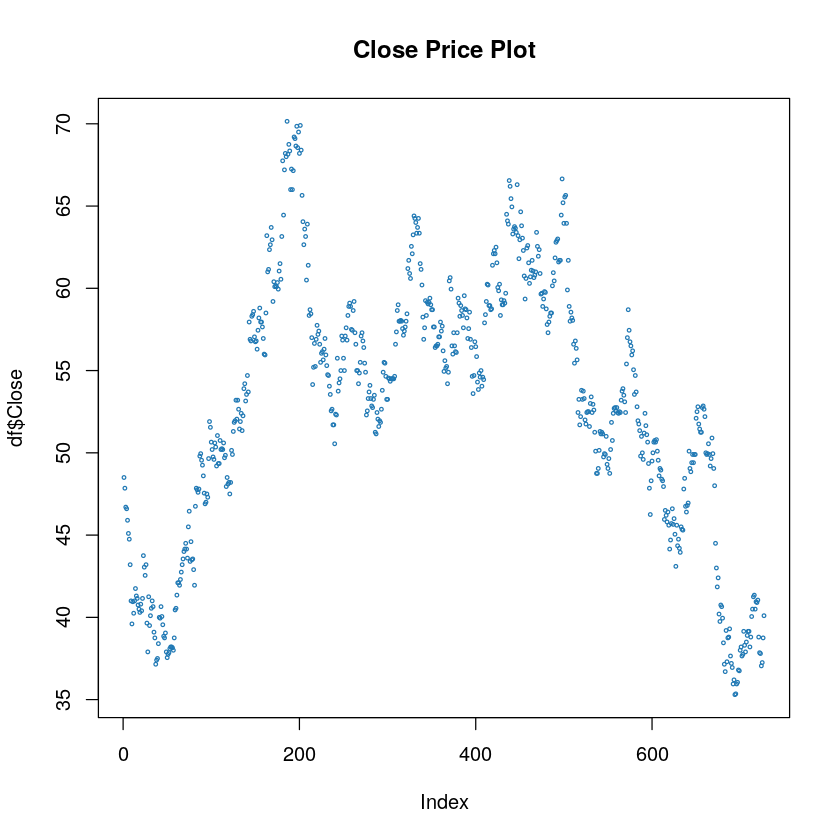

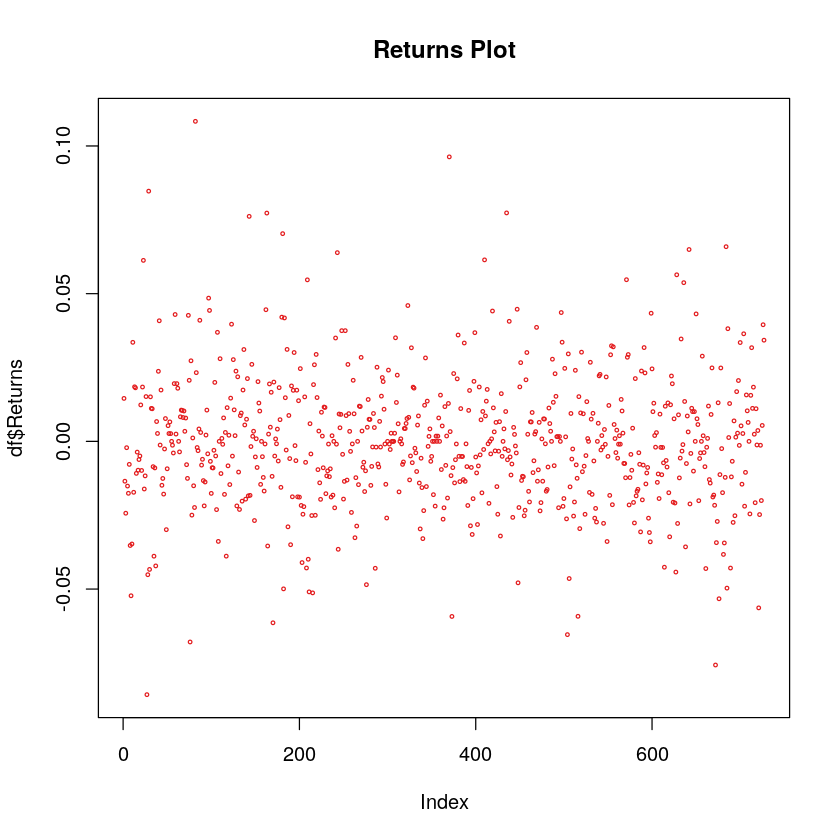

In [439]:
df=df[complete.cases(df),]

col_name=c("Close", "Returns")

par(mfrow=c(1,1))
    plot(df$Close,  col=my_palette[1] , cex = .4, pch=1, main="Close Price Plot")
    plot(df$Returns,col=my_palette[2], cex = .4, pch=1, main="Returns Plot")
    

## 2.1 Conclusion

* We can easily conclude that Closing price of stocks are not stationary while the Returns are stationary.
*  But, still we would like to use a more mathematical approach rather than visual approach to make stronger conclusion.


#### So, we perform ADF(Augmented Dickey–Fuller) test with
* H0: Series is not stationary 
* H1: Series is stationary


##### We hope that we can reject the null hypothesis to continue with ARIMA modeling

## 2.2 Stationarity Check by Augmented Dickey–Fuller Test

In [440]:
adf.test(x=df$Returns)

Warning message in adf.test(x = df$Returns):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  df$Returns
Dickey-Fuller = -9.5465, Lag order = 8, p-value = 0.01
alternative hypothesis: stationary


## 2.2 Conclusion

* The p-value  is less than 0.05 and hence we can reject the null hypothisis.
* Thus our alternate Hypostehis stands winner: H1: Serie is stationary and we can proceed further.


## 2.3.A. Finding AR and MA component : Visual Method
* Reason: As the I component is zero for returns, from checks 2.1 and 2.2 done above 

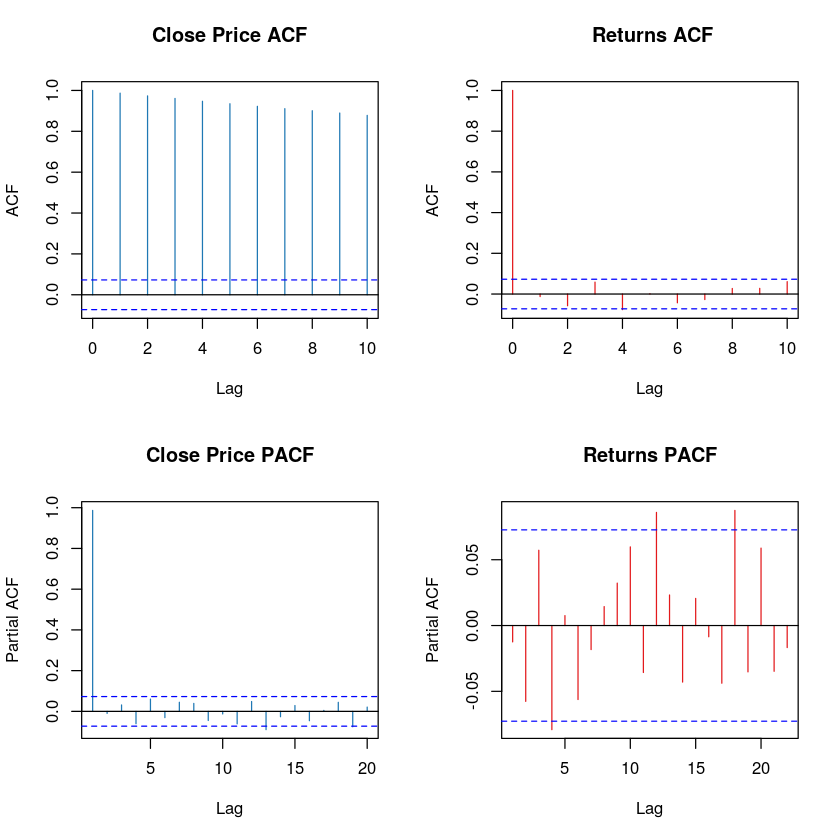

In [441]:
par(mfrow=c(2,2))
    acf(df$Close, 10,   col=my_palette[1], main="Close Price ACF")
    acf(df$Returns,10, col=my_palette[2], main=" Returns ACF")
    pacf(df$Close,20, col=my_palette[1], main="Close Price PACF")
    pacf(df$Returns,22, col=my_palette[2], main="Returns PACF")


## 2.3.A. Conclusion 

* From PACF plot AR:04 
* From ACF   plot MA: 0
* Our model is of thus type ARIMA(04,0,0)

## 2.4.A. Fitting the model: Attempt 1 -> (4,0,0)
* We also save the residuals to run diagnostic checks

In [442]:
model_1_order=c(4,0,0)
model_1=arima(df$Returns, order=model_1_order)
model_1r=model_1$residuals

## 2.5.A  Method 1: Running Diagnostice checks on residuals: Visual Method

### Expectations:

1. Residuals should be normally distributed and do not tilt towards left(right-ly skewed) or towards right (left-ly skewed).
2. ACF plot of lag variables should not show any crossing (or should not be realted to its lag values), if they do so than our we are still misisng one or more predictor varibales  
3. Residuals graph should be themself stationary, else they will sugesst that we still have trends in  our data which is unacoanted in  fitted model


##### We use a quick function "checkresiduals" to save our time 

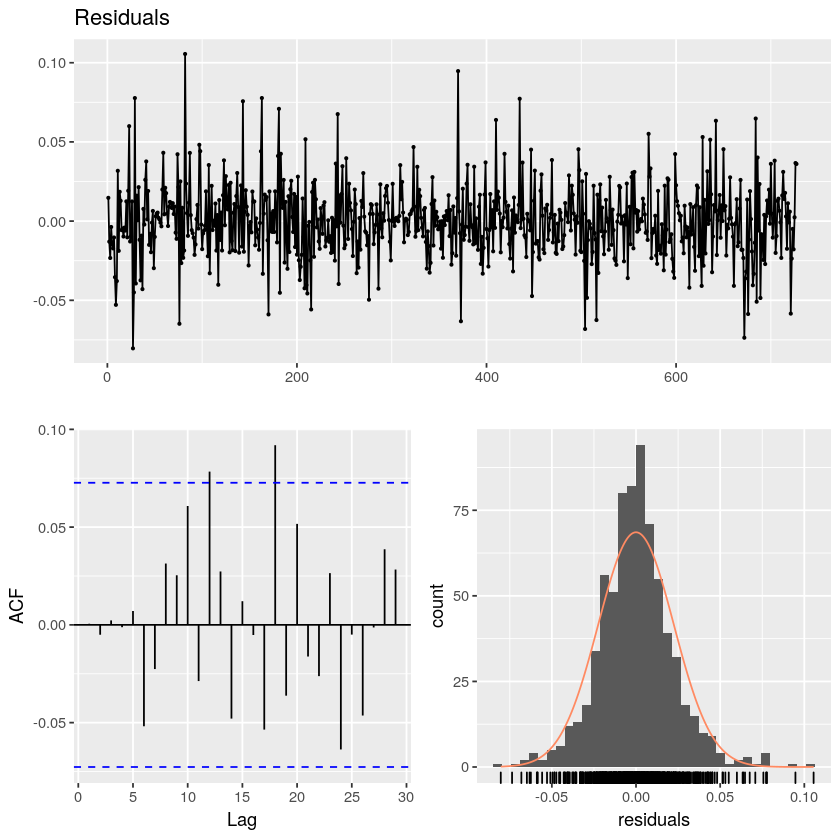

In [443]:
## https://www.itl.nist.gov/div898/handbook/pmc/section6/pmc624.htm
checkresiduals(model_1$residuals)

## 2.5.A Method 1: Result and Conclusion
1. Our residuals are normally distibuted, more over they are centered between -0.5 and +0.5.
2. The ACF plot of lagged values of residuals are not correlated for atlease 12 lags.
3. Residual graph is stationary and thus we do not find any unaccounted trend in data.


#### Thus, our model has passed all the diagnostic test  and we can proceed to predict on test set.

## 2.5.A Method 2 Running Diagnostice checks on residuals: Ljung–Box Test

#####  Ljung-Box test is used to find if the series has any autocorrelation:

1. H0: Series do not have Auto Correlation.
2.  H1: Series have Auto Correlation.

### Expectation:
1. P value should be more than 0.05 so that we cannot reject H0: hence our series will be declaered independent of autocorrelation

In [444]:
Box.test(model_1$residuals, type="Ljung-Box")


	Box-Ljung test

data:  model_1$residuals
X-squared = 0.00024188, df = 1, p-value = 0.9876


## 2.5.A Method 2 Result and Conclusion
1. As expected P value is more than 0.05, hence we cannot reject H0: hence our series is now declaered independent of autocorrelation

#### Thus, our model has passed all the diagnostic test  and we can proceed to predict on test set.

### -------------------------------------------------------------
# Part B:
### --------------------------------------------------------------


## 2.3.B. Finding AR and MA component : Software recommedation (Auto ARIMA)

In [445]:
auto.arima(df$Returns)

Series: df$Returns 
ARIMA(2,0,3) with non-zero mean 

Coefficients:
          ar1      ar2     ma1     ma2      ma3    mean
      -1.5168  -0.8499  1.5183  0.8067  -0.0058  -2e-04
s.e.   0.1268   0.0695  0.1303  0.1106   0.0652   8e-04

sigma^2 estimated as 0.0005059:  log likelihood=1730.08
AIC=-3446.16   AICc=-3446   BIC=-3414.03

## 2.3.B. Conclusion

*  Auto ARIMA suggest us to use (0,0,0) model

## 2.4.B. Fitting the model: Attempt 2 -> (2,0,3)
* We also save the residuals to run diagnostic checks

In [446]:
model_2_order=c(2,0,3)
model_2=arima(df$Returns, order=model_2_order)
model_2r=model_2$residuals

## 2.5.A Method 1: Running Diagnostice checks on residuals: Visual Method¶
### Expectations:
1. Residuals should be normally distributed and do not tilt towards left(right-ly skewed) or towards right (left-ly skewed).
2. ACF plot of lag variables should not show any crossing (or should not be realted to its lag values), if they do so than our we are still misisng one or more predictor varibales
3. Residuals graph should be themself stationary, else they will sugesst that we still have trends in our data which is unacoanted in fitted model

##### We use a quick function "checkresiduals" to save our time¶

##### Running visual diagnostic in model_2

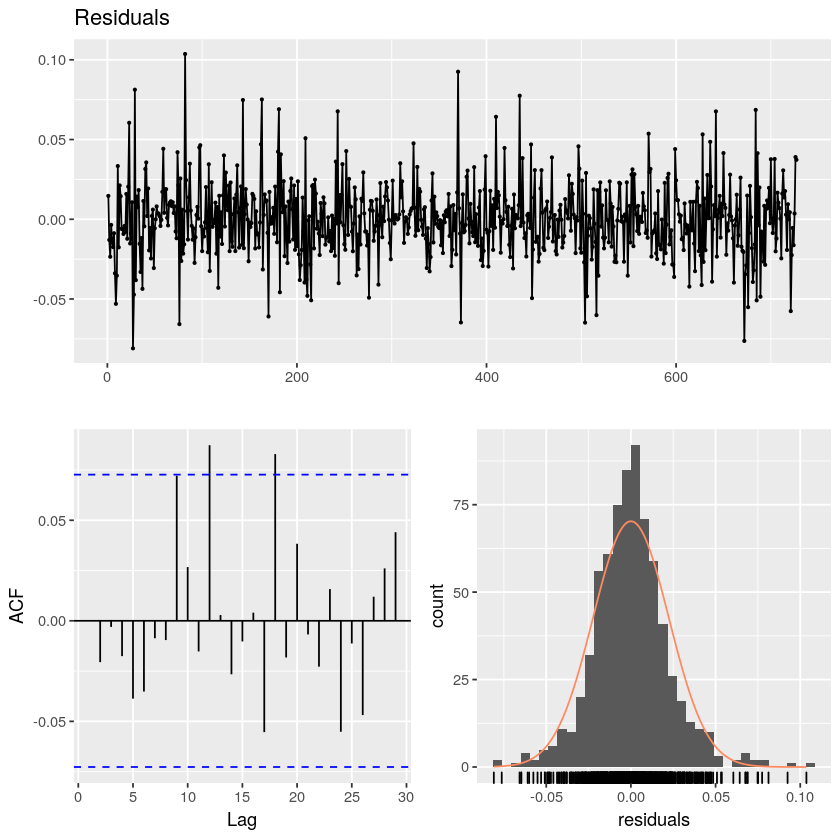

In [447]:
checkresiduals(model_2$residuals)

## 2.5.B Method 1: Result and Conclusion

1. Inspite of normality of residuals, our residuals have some correaltion as lines are been crossed in ACF plot
2. But, since convincing via visual proof is hard, let us perform Ljung–Box Test


## 2.5.B Method 2 Running Diagnostice checks on residuals: Ljung–Box Test

#####  Ljung-Box test is used to find if the series has any autocorrelation:

1. H0: Series do not have Auto Correlation.
2.  H1: Series have Auto Correlation.

### Expectation:
1. P value should be more than 0.05 so that we cannot reject H0: hence our series will be declaered independent of autocorrelation

In [448]:
Box.test(model_2$residuals, type="Ljung-Box", lag=3)


	Box-Ljung test

data:  model_2$residuals
X-squared = 0.3151, df = 3, p-value = 0.9572


## 2.5.B Method 2 Result and Conclusion

1. As expected P value is more than 0.05, hence we cannot reject H0: hence our series is now declaered independent of autocorrelation

#### Thus, our model has passed all the diagnostic test and we can proceed to predict on test set.

### 2.5.1 Adding fitted values of model_1 and model_2 to dataframe 

In [449]:
df$fit_1=as.numeric(df$Returns- model_1$residuals)
df$fit_2=as.numeric(df$Returns- model_2$residuals)
head(df)

,Date,Close,Returns,fit_1,fit_2
2568,2016-01-05,48.50,0.014538179,-0.0001515641,-0.0001157867
2569,2016-01-06,47.85,-0.013492722,-0.0005148855,-0.0005398177
2570,2016-01-07,46.70,-0.024326890,-0.0010352315,-0.0008238890
2571,2016-01-08,46.60,-0.002143688,0.0015722670,0.0014024971
2572,2016-01-11,45.90,-0.015135338,-0.0006742534,-0.0010696938
2573,2016-01-12,45.10,-0.017582958,-0.0003531854,-0.0001642572


## 2.6 Making Predictions from test set.

In [450]:
df_model_1=forecast(model_1,h=delta)
df_model_1=as.data.frame(df_model_1)


df_model_2=forecast(model_2,h=delta)
df_model_2=as.data.frame(df_model_2)

df_model_2

,Point Forecast,Lo 80,Hi 80,Lo 95,Hi 95
728,0.0017287289,-0.02697607,0.03043353,-0.04217148,0.04562894
729,-0.0027021328,-0.03140697,0.02600271,-0.04660239,0.04119813
730,0.0015922848,-0.02714232,0.03032689,-0.04235351,0.04553808
731,-0.0009383587,-0.02972795,0.02785123,-0.04496824,0.04309152
732,-0.0007496774,-0.02958293,0.02808357,-0.04484633,0.04334697
733,0.0011148664,-0.02773225,0.02996198,-0.04300299,0.04523272
734,-0.0018735680,-0.03072068,0.02697355,-0.04599142,0.04224429
735,0.0010745632,-0.02778223,0.02993136,-0.04305809,0.04520722
736,-0.0008572716,-0.02973659,0.02802205,-0.04502438,0.04330984
737,-0.0004326693,-0.02933274,0.02846740,-0.04463151,0.04376617


### 2.6.1 Adding predicted values of mode_1 and two as fitted values of test dataframe

In [451]:
df2$fit_1=df_model_1$Point
df2$fit_2=df_model_2$Point
head(df2)

,Date,Close,Returns,fit_1,fit_2
3295,2018-12-14,39.65,-0.011285286,-0.0009857377,0.0017287289
3296,2018-12-17,39.95,0.007537699,-0.0005753143,-0.0027021328
3297,2018-12-18,41.15,0.029595278,-0.0014100297,0.0015922848
3298,2018-12-19,41.90,0.018061899,-0.0029926049,-0.0009383587
3299,2018-12-20,44.00,0.048903759,-0.0001212389,-0.0007496774
3300,2018-12-21,42.90,-0.025317761,-0.0001189821,0.0011148664


### 2.7 Appending Test set to Train set

In [452]:
df_all=rbind(df, df2)
str(df_all)

'data.frame':	737 obs. of  5 variables:
 $ Date   : Date, format: "2016-01-05" "2016-01-06" ...
 $ Close  : num  48.5 47.8 46.7 46.6 45.9 ...
 $ Returns: num  0.01454 -0.01349 -0.02433 -0.00214 -0.01514 ...
 $ fit_1  : num  -0.000152 -0.000515 -0.001035 0.001572 -0.000674 ...
 $ fit_2  : num  -0.000116 -0.00054 -0.000824 0.001402 -0.00107 ...


### 3.0 Preparing Legends for graph

In [453]:
model_1_order_c="(4,0,0)"
model_2_order_c="(2,0,3)"
color_val=c(
            paste("ARIMA",model_1_order_c," Fit"),
            paste("ARIMA",model_1_order_c," Predicted"),
            paste("ARIMA",model_2_order_c," Fit"),
            paste("ARIMA",model_2_order_c," Predicted")
            )

# 3.A Plotting Model 1:ARIMA(4,0,0)

Warning message:
“Removed 1 rows containing missing values (geom_path).”

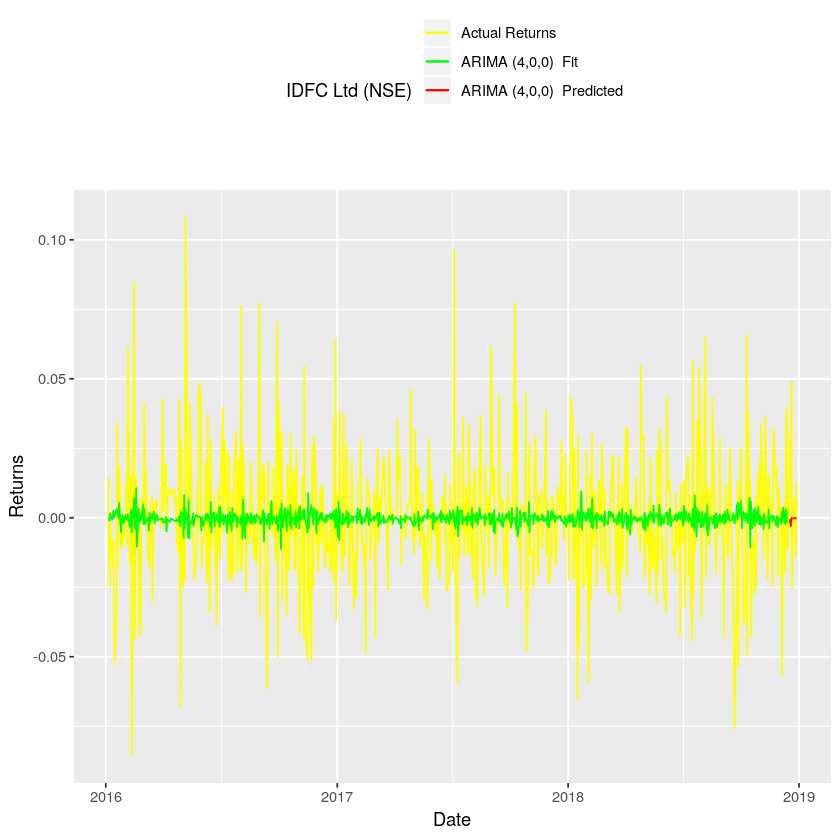

In [454]:
ggplot()+
    
    geom_line(data=df_all, aes(x=Date, y=Returns, color="Actual Returns") )+


    geom_line(data=df_all[start:split,], aes(x=Date, y=fit_1, color=color_val[1]) )+
    geom_line(data=df_all[(split+1):total,], aes(x=Date, y=fit_1, color=color_val[2]) )+

    
#     geom_line(data=df_all[start:split,], aes(x=Date, y=fit_2, color=color_val[3]))+
#     geom_line(data=df_all[(split+1):total,], aes(x=Date, y=fit_2, color=color_val[4]))+
    
    scale_color_manual(values=c(
    "yellow",
    "green",
    "red"
#     "brown",
#     "black"
    ))+
    labs(color="IDFC Ltd (NSE)")+
    theme(legend.position="top")+ guides(colour = guide_legend(nrow = 5))+
    ylab("Returns")

# 3.B Plotting Model 2:ARIMA(2,0,3)

Warning message:
“Removed 1 rows containing missing values (geom_path).”

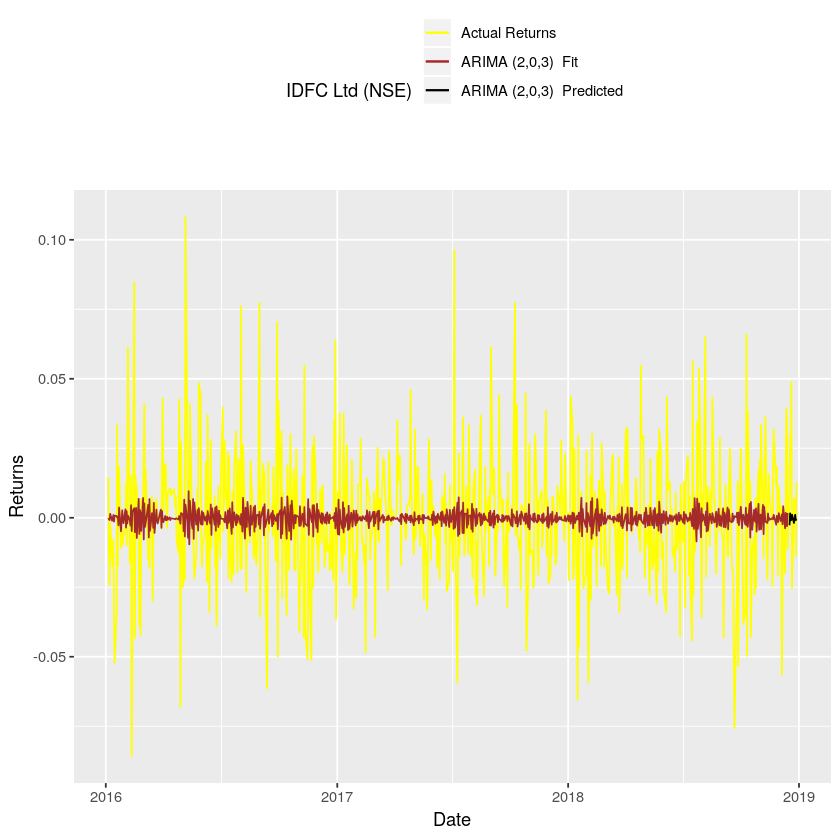

In [455]:

ggplot()+
    
    geom_line(data=df_all, aes(x=Date, y=Returns, color="Actual Returns") )+


#     geom_line(data=df_all[start:split,], aes(x=Date, y=fit_1, color=color_val[1]) )+
#     geom_line(data=df_all[(split+1):total,], aes(x=Date, y=fit_1, color=color_val[2]) )+

    
    geom_line(data=df_all[start:split,], aes(x=Date, y=fit_2, color=color_val[3]))+
    geom_line(data=df_all[(split+1):total,], aes(x=Date, y=fit_2, color=color_val[4]))+
    
    scale_color_manual(values=c(
    "yellow",
#     "green",
#     "red",
    "brown",
    "black"
    ))+
    labs(color="IDFC Ltd (NSE)")+
    theme(legend.position="top")+ guides(colour = guide_legend(nrow = 5))+
    ylab("Returns")

# 3. (A,B) Plot:  Model 1 vs Model 2

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”

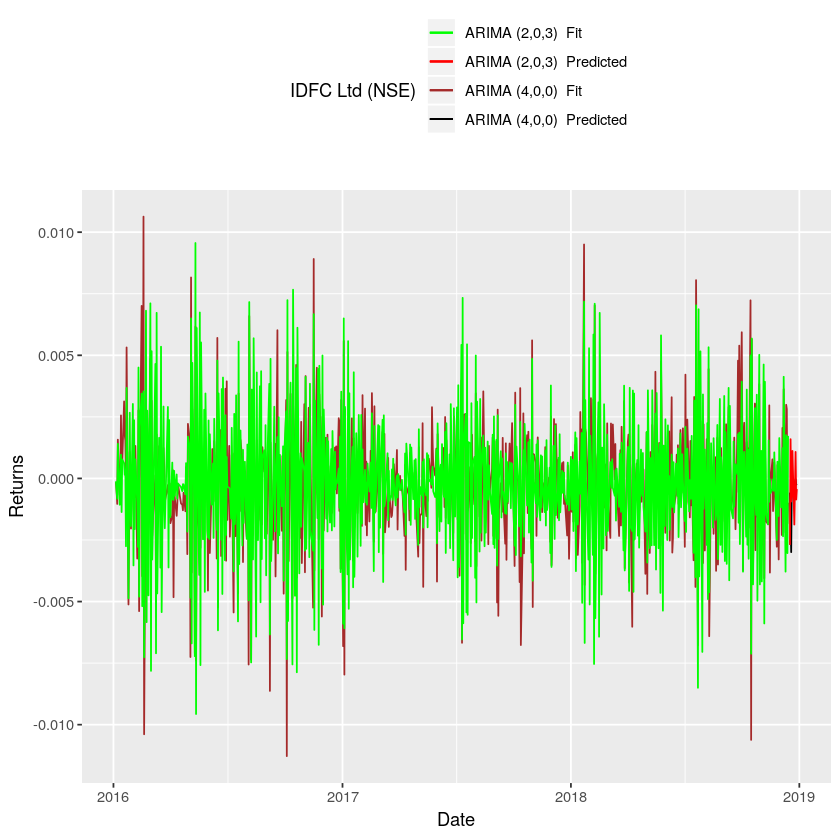

In [456]:
ggplot()+
    
#     geom_line(data=df_all, aes(x=Date, y=Returns, color="Actual Returns") )+


    geom_line(data=df_all[start:split,], aes(x=Date, y=fit_1, color=color_val[1]) )+
    geom_line(data=df_all[(split+1):total,], aes(x=Date, y=fit_1, color=color_val[2]) )+
    
    geom_line(data=df_all[start:split,], aes(x=Date, y=fit_2, color=color_val[3]))+
    geom_line(data=df_all[(split+1):total,], aes(x=Date, y=fit_2, color=color_val[4]))+
    
    scale_color_manual(values=c(
#     "yellow",
    "green",
    "red",
    "brown",
    "black"
    ))+
    labs(color="IDFC Ltd (NSE)")+
    theme(legend.position="top")+ guides(colour = guide_legend(nrow = 5))+
    ylab("Returns")
    

# 4. Finding Model Accuracy


## There are 4 methods available to find model accuracy:

* Help Article: http://www.acheronanalytics.com/acheron-blog/how-to-measure-the-accuracy-of-predictive-models

##### 1. MAE

$$ \frac{1}{n} \sum\limits_n^{t=1} |A_t-F_t|  $$

* Which we reject as they do not take into account the effect of magnitude of data. And our MAE value will always be very small as day-to-day returns are very small.
* This will alwyas understate our model errors.

##### 2. RMSE

$$ \sqrt \frac {\sum |A_t-F_t|^2}{n} $$

* Which we reject as they do not take into account the effect of magnitude of data. And our RMSE value will always be very small as day-to-day returns are very small.
* This will alwyas understate our model errors.

##### 3. MAPE
$$  \left\{ \frac{1}{n} \sum \frac {|A_t-F_t|}{|A_t|} \right\} x 100  $$
* We accept MAPE as it takes the percentage diffrence hence eliminating the scaling effect we see above.

##### 4. MASE

$$ \frac {MAE}{MAE_{NaiveModel}} $$

* We accept MAPE as it takes the percentage diffrence hence eliminating the scaling effect we see above.
* But, also we compare our model with the NAIVE method, this tells us wether all our Hardwork performing the ARMIA can be just be performed better by NAIVE method.
1.  If MASE is larger than 1, then we ARIMA modeling was useless and 
2.  If MASE is smaller than 1, then our model was better than ARIMA.

## 4.1 Accuracy by MAPE

In [457]:
attach(df2)

The following objects are masked from df2 (pos = 3):

    Close, Date, fit_1, fit_2, Returns

The following objects are masked from df2 (pos = 4):

    Close, Date, fit_1, fit_2, Returns

The following objects are masked from df2 (pos = 5):

    Close, Date, fit_1, fit_2, Returns

The following objects are masked from df2 (pos = 6):

    Close, Date, fit_1, fit_2, Returns

The following objects are masked from df2 (pos = 7):

    Close, Date, fit_1, fit_2, Returns

The following objects are masked from df2 (pos = 8):

    Close, Date, fit_1, fit_2, Returns

The following objects are masked from df2 (pos = 9):

    Close, Date, fit_1, fit_2, Returns

The following objects are masked from df2 (pos = 10):

    Close, Date, fit_1, fit_2, Returns

The following objects are masked from df2 (pos = 11):

    Close, Date, fit_1, fit_2, Returns

The following objects are masked from df2 (pos = 12):

    Close, Date, fit_1, fit_2, Returns



In [458]:
print("-------------------------MAPE Analysis-------------------------------")
print(paste("ARIMA(18,0,0):", round(mape(Returns, fit_1)*100,2 )))
print(paste("ARIMA(0,0,0) :", round(mape(Returns, fit_2)*100,2 )))
print("----------------------------------------------------------------------")

[1] "-------------------------MAPE Analysis-------------------------------"
[1] "ARIMA(18,0,0): 102.55"
[1] "ARIMA(0,0,0) : 106.24"
[1] "----------------------------------------------------------------------"


## 4.2 Accuracy by MASE

In [459]:
print("-------------------------MASE Analysis-------------------------------")
print(paste("ARIMA(18,0,0):", round(mase(Returns, fit_1),2 )))
print(paste("ARIMA(0,0,0) :", round(mase(Returns, fit_2),2 )))
print("----------------------------------------------------------------------")

[1] "-------------------------MASE Analysis-------------------------------"
[1] "ARIMA(18,0,0): 0.7"
[1] "ARIMA(0,0,0) : 0.71"
[1] "----------------------------------------------------------------------"


# 5 Conclusion

#### From we can conclude following


1. From MAPE: Error percentage of model is 102% hence the predictions are of no use.
2. From MASE: But, inspite of having 102% error, our model was better than NAIVE appraoch, hence we should further develop this model_1 which ARIMA(4,0,0). 
3. If we go back to point 3. of our story, we notice that red lines are highly fluctuating and thus may encompas a seasonlity and cyclity too, But we never decomposed our model to remove them and hence have a predication with very high error.
4. To renforce our point 4 let us plot the moving average and fitted values of all data which will show that our model acutally have learned only average or trend of pattern and not seasonlity which is present in highly volatile stock prices.



Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Warning message:
“Removed 4 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”

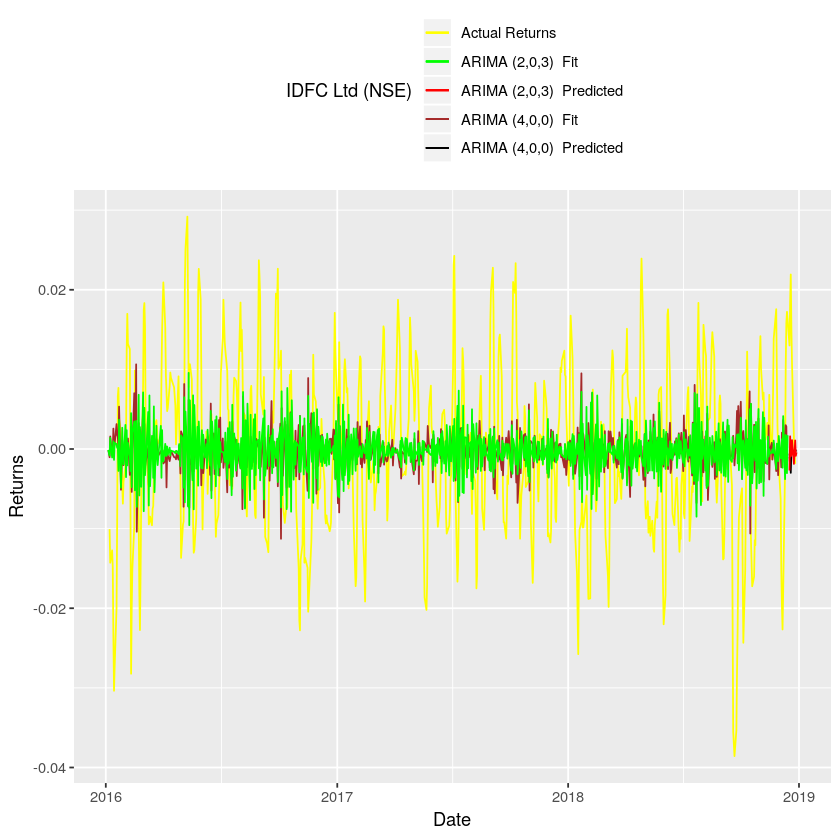

In [462]:
ma=4
df_all$ma_ret=ma(df_all$Returns, order=ma)
df_all$ma_fit1=ma(df_all$fit_1, order=ma)
df_all$ma_fit2=ma(df_all$fit_2, order=ma)


ggplot()+
    
    geom_line(data=df_all, aes(x=Date, y=ma_ret, color="Actual Returns") )+


    geom_line(data=df_all[start:split,], aes(x=Date, y=fit_1, color=color_val[1]) )+
    geom_line(data=df_all[(split+1):total,], aes(x=Date, y=fit_1, color=color_val[2]) )+

    
    geom_line(data=df_all[start:split,], aes(x=Date, y=fit_2, color=color_val[3]))+
    geom_line(data=df_all[(split+1):total,], aes(x=Date, y=fit_2, color=color_val[4]))+
    
    scale_color_manual(values=c(
    "yellow",
    "green",
    "red",
    "brown",
    "black"
    ))+
    labs(color="IDFC Ltd (NSE)")+
    theme(legend.position="top")+ guides(colour = guide_legend(nrow = 5))+
    ylab("Returns")